# Jena Flowers 30 Dataset
Seeland, Marco; Rzanny, Michael; Alaqraa, Nedal; Wäldchen, Jana; Mäder, Patrick, 2017, "Jena Flowers 30 Dataset", https://doi.org/10.7910/DVN/QDHYST, Harvard Dataverse, V1

# Part 1: Build a basic model with CNN layers

## Step 1: Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd  
from sklearn.model_selection import train_test_split   
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

1.14.0


Using TensorFlow backend.


## Step 2: Import Data

In [2]:
#import classlabel.txt to create dataframe for image processing
head=['file','class']
data=pd.read_csv('classlabels.txt', sep="," ,names=head)
data['class']=data['class'].astype(str)
data.head()

,file,class
0,JFT_00001.jpg,1
1,JFT_00002.jpg,1
2,JFT_00003.jpg,1
3,JFT_00004.jpg,1
4,JFT_00006.jpg,1


In [3]:
#create lists for file name and class label
X=data['file']
y=data['class']

In [4]:
#split data into training and test sets, using 80/20 split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
#extract the file names for both training and validation sets into lists
X_train_l = X_train.tolist()
X_validation_l = X_validation.tolist()
y_train_l=y_train.tolist()
y_validation_l=y_validation.tolist()

In [6]:
#iterate through the training and validation lists and put them into separate folders

import os
import shutil

src = 'jpg' #source of all images
dest_train = 'train' #need to manually create a directory called 'train' in the same folder before running this.
dest_validation = 'validation' #need to manually create a directory called 'validation' in the same folder before running this.

#move to images to the train folder
for file in os.listdir(src):
    if file in X_train_l:
        name = os.path.join(src, file )
    if os.path.isfile( name ) :
        shutil.copy( name, dest_train)
    else :
        print ('file does not exist', name)

#move to images to the validation folder
for file in os.listdir(src):
    if file in X_validation_l:
        name = os.path.join(src, file )
    if os.path.isfile( name ) :
        shutil.copy( name, dest_validation)
    else :
        print ('file does not exist', name)   

In [8]:
#create a dataframe for training set
train_dataset = pd.DataFrame({'file': X_train, 'label': list(y_train)}, columns=['file', 'label'])
train_dataset.head()


,file,label
632,JFT_00127.jpg,4
317,JFT_00812.jpg,18
1125,JFT_00921.jpg,20
58,JFT_00144.jpg,4
241,JFT_00644.jpg,13


In [9]:
#create a dataframe for validation set
validation_dataset = pd.DataFrame({'file': X_validation, 'label': y_validation}, columns=['file', 'label'])
validation_dataset.head()

,file,label
567,JFT_00019.jpg,2
1041,JFT_00794.jpg,18
649,JFT_00153.jpg,4
666,JFT_00175.jpg,4
568,JFT_00025.jpg,2


In [10]:
#read numpy values of training and validation images using a for loop 
from matplotlib import image
train_images = list()
validation_images=list()

for filename in X_train_l:
    train_img = image.imread('train/' + filename) # load image
    train_images.append(train_img) # store loaded image
    #print('> loaded %s %s' % (filename, train_img.shape))
   

for filename in X_validation_l:
    validation_img = image.imread('validation/' + filename) # load image
    validation_images.append(validation_img) # store loaded image
    #print('> loaded %s %s' % (filename, validation_images.shape))


### Explore the data

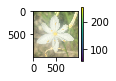

In [11]:
#display the first training image using the image numpy values created from above
plt.figure(figsize = (1,1))
img1 = train_images[1]
plt.imshow(img1)
plt.colorbar()
plt.grid(False)

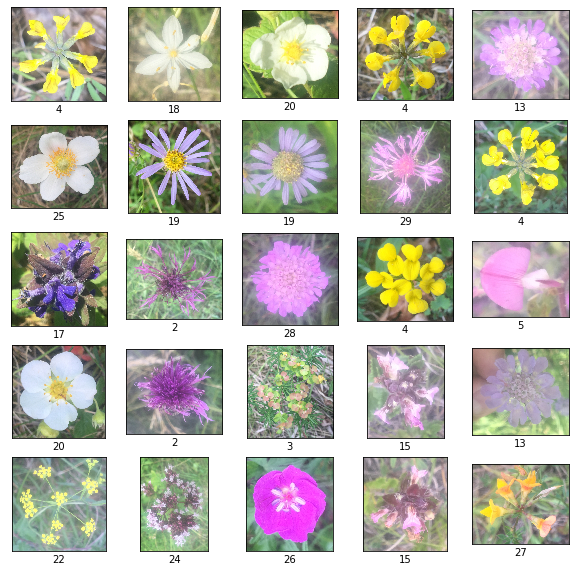

In [12]:
#display the first 25 training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(y_train_l[i])

In [13]:
#number of samples in the training images
len(y_train)

1183

In [14]:
#explore the shape of the first two training images
#notice that images do not have the same shapes
print ('shape of the 1st training image:', train_images[1].shape)
print ('shape of the 2nd training image:', train_images[2].shape)


shape of the 1st training image: (991, 970, 3)
shape of the 2nd training image: (520, 569, 3)


In [15]:
#number of samples in the validation images
len(y_validation)

296

## Step 3: Image Preprocessing using Keras

In [16]:
#Based on what we have observed, the images do not have the same shape. Thus, we need to do a little preprocessing work
#before we start to train the model. We can use the Image Preprocessing tool from Keras to rescale and reshape the data. 
train_datagen = ImageDataGenerator(
        rescale=1./255.,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_dataset,
directory="./train/",
x_col="file",
y_col="label",
batch_size=32,
class_mode="sparse",
target_size=(32,32))


validation_generator=validation_datagen.flow_from_dataframe(
dataframe=validation_dataset,
directory="validation",
x_col="file",
y_col="label",
batch_size=32,
class_mode="sparse",
target_size=(32,32))

Found 1183 images belonging to 30 classes.
Found 296 images belonging to 30 classes.


## Step 4: Build Model

#### Baseline Model

In [17]:
train_dataset['label'].describe()


count     1183
unique      30
top          6
freq        57
Name: label, dtype: object

Using the training set as the baseline model:

57/1183=0.04818, or 4.818% is the baseline for the model. 

#### Build Model - Setup the layers

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64,(4, 4)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.3))
 
model.add(Conv2D(64, (4, 4), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.3))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output classes are 30
model.add(Dense(30))
model.add(Activation('softmax'))

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 64)        32832     
_________________________________________________________________
activation_14 (Activation)   (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 64)          0         
__________

#### Compile the model

In [30]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train the model

In [31]:
history=model.fit_generator(
        train_generator,
        steps_per_epoch=1183,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=296)

Epoch 1/5
1183/1183 [==============================] - 466s 394ms/step - loss: 0.9443 - acc: 0.6987 - val_loss: 0.5091 - val_acc: 0.8279
Epoch 2/5
1183/1183 [==============================] - 464s 392ms/step - loss: 0.2341 - acc: 0.9221 - val_loss: 0.2229 - val_acc: 0.9295
Epoch 3/5
1183/1183 [==============================] - 465s 393ms/step - loss: 0.1381 - acc: 0.9554 - val_loss: 0.2779 - val_acc: 0.9255
Epoch 4/5
1183/1183 [==============================] - 465s 393ms/step - loss: 0.1054 - acc: 0.9661 - val_loss: 0.3493 - val_acc: 0.9222
Epoch 5/5
1183/1183 [==============================] - 464s 392ms/step - loss: 0.0875 - acc: 0.9715 - val_loss: 0.2412 - val_acc: 0.9391


#### Lowest Validation Error

In [33]:
print(min(history.history['val_acc']))

0.827939835916135


## Step 5: Plot Results

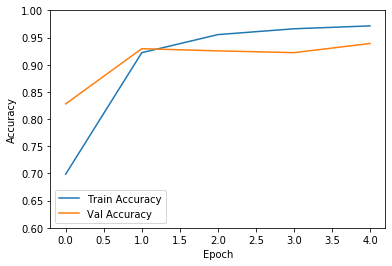

In [35]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['acc']),
           label='Train Accuracy')
  plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Accuracy')
  plt.legend()
  plt.ylim([0.6, 1])

plot_history(history)

# Part 2: Build a Transfer Model using the fine tuning approach

## Step 1: Load the VGG model

In [34]:
#load the VGG model from Keras
vgg_conv = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [35]:
#use the Image Preprocessing tool from Keras to rescale and reshape the data. 
train_datagen = ImageDataGenerator(
        rescale=1./255.,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_dataset,
directory="./train/",
x_col="file",
y_col="label",
batch_size=32,
class_mode="sparse",
target_size=(32,32))


validation_generator=validation_datagen.flow_from_dataframe(
dataframe=validation_dataset,
directory="validation",
x_col="file",
y_col="label",
batch_size=32,
class_mode="sparse",
target_size=(32,32))

Found 1183 images belonging to 30 classes.
Found 296 images belonging to 30 classes.


In [36]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001CA0809DD68> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001CA1CFFB240> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001CA06343AC8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001CA0A6E13C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001CA05F28748> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001CA05F35D68> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001CA05F55E80> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001CA05F98390> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001CA05FB59B0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001CA05FCF4A8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001CA06001710> False
<tensorflow.python.

## Step 2: Build the model and add new layers

In [37]:
# Create the model and add new layers
transfer_learning_model = tf.keras.Sequential([
    (vgg_conv),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(30, activation='softmax')
    ])
    

# Show a summary of the model. Check the number of trainable parameters
transfer_learning_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

### Compile and train the model

In [38]:
# compile the transfer learning model
transfer_learning_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# train the model
history_tl = transfer_learning_model.fit_generator(
      train_generator,
      steps_per_epoch=1183 ,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=296,
      verbose=1)


Epoch 1/5
1183/1183 [==============================] - 935s 791ms/step - loss: 1.3743 - acc: 0.5953 - val_loss: 0.4437 - val_acc: 0.8409
Epoch 2/5
1183/1183 [==============================] - 840s 710ms/step - loss: 0.1552 - acc: 0.9568 - val_loss: 0.2691 - val_acc: 0.9087
Epoch 3/5
1183/1183 [==============================] - 805s 681ms/step - loss: 0.0604 - acc: 0.9844 - val_loss: 0.2435 - val_acc: 0.9223
Epoch 4/5
1183/1183 [==============================] - 791s 669ms/step - loss: 0.0502 - acc: 0.9871 - val_loss: 0.3488 - val_acc: 0.9157
Epoch 5/5
1183/1183 [==============================] - 821s 694ms/step - loss: 0.0376 - acc: 0.9911 - val_loss: 0.2805 - val_acc: 0.9190


## Step 3: Plot Results for the Transfer Model 

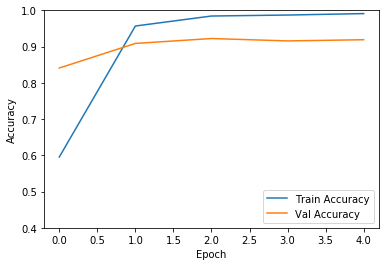

In [39]:
def plot_history(history_tl):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history_tl.epoch, np.array(history_tl.history['acc']),
           label='Train Accuracy')
  plt.plot(history_tl.epoch, np.array(history_tl.history['val_acc']),
           label = 'Val Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([0.4, 1])

plot_history(history_tl)